In [1]:
%load_ext autoreload
%autoreload 1
%reload_ext autoreload


%aimport src.utils.tardisml_utils

In [2]:
import xarray as xr
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import yaml
import pickle as pkl

import src.utils.load_config as load_config
import src.data_preparation.load_data as load_data
import src.feature_extraction.pca as feature_pca
import src.visualization.visualize_pca as visualize_pca
import src.visualization.visualize_error as visualize_error
from src.visualization.visualize_local_area import plot_land_mask

import src.utils.tardisml_utils as tardisml_utils
rootdir = tardisml_utils.get_rootdir()
#import tardis_ml

login-1.fram.sigma2.no
fram detected
login-1.fram.sigma2.no
fram detected
login-1.fram.sigma2.no
fram detected
login-1.fram.sigma2.no
fram detected
login-1.fram.sigma2.no
fram detected


# Configuration

In [3]:
# Date to plot in example
idate = 100
# Path to config file
# file_config = '../config/data_proc_demo.yaml'
file_config = '../config/data_proc_full.yaml'
# Path to template file
file_template = '../config/template_name.yaml'

template = yaml.load(open(file_template),Loader=yaml.FullLoader)
load_config.update_config(file_config, verbose=True)
nosit_dir, withsit_dir, _, forcing_bdir, pca_dir, res_dir, fig_dir, ml_dir = load_config.load_filename(file_config)
timeofday, target_field, forcing_fields, covar_fields, lim_idm, lim_jdm, n_comp = load_config.load_config_params(file_config)

PCA results in: /nird/projects/nird/NS2993K/Leo/results/pca_i100-550_j300-629
Config file updated (pca_dir): ../config/data_proc_full.yaml
Config file updated: ../config/data_proc_full.yaml
Results in: /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_7F_rw21d_N4444_H1333_Hn0000_sithick_noname_220928-130121
Folder created

Config file updated.


In [4]:
rootdir+pca_dir

'/nird/projects/nird/NS2993K/Leo/results/pca_i100-550_j300-629'

- mslprs: Mean sea-level pressure
- airtmp: Air temperature
- vapmix
- precip
- ---
- wndewd
- wndnwd

In [5]:
# copy config file to results
#!cp {file_config} {rootdir+config['user']+res_dir}

# Data Preparation

## Define chronology

In [4]:
# chrono from files in TP4c
from datetime import datetime
from datetime import timedelta

from glob import glob

listfile = sorted(glob(os.path.join(rootdir + nosit_dir,'*.nc')))
listfields = sorted([os.path.basename(name) for name in listfile])

dt = np.array([datetime.strptime(lf[:8], "%Y%m%d") for lf in listfields])
chrono = pd.DataFrame({'date':dt})        

In [6]:
chrono

,date
0,2010-09-29
1,2010-09-30
2,2010-10-01
3,2010-10-02
4,2010-10-03
...,...
3011,2018-12-27
3012,2018-12-28
3013,2018-12-29
3014,2018-12-30


In [7]:
chrono.loc[0].date.year

2010

## Load SIT (Sea Ice Thickness)

In [5]:
template

{'dailync': 'TP4DAILY_{year:04d}_{dayinyear:03d}.nc',
 'dailync_full': '{year:04d}{month:02d}{day:02d}_dm-12km-NERSC-MODEL-TOPAZ4B-ARC-RAN.fv2.0.nc'}

In [9]:
nc1 = xr.open_dataset(os.path.join(rootdir, withsit_dir, template['dailync_full'].format(year=2010, month=1, day=1)))

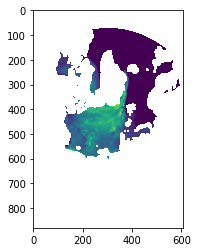

In [12]:
plt.imshow(nc1['sisnthick'][0])

In [11]:
nc1['sisnthick'][0].shape

(881, 609)

In [13]:
nc1['latitude'][0]

<xarray.DataArray 'latitude' (x: 609)>
array([34.686497, 34.73653 , 34.786472, ..., 34.786472, 34.73653 , 34.686497],
      dtype=float32)
Coordinates:
    latitude   (x) float32 ...
    longitude  (x) float32 ...
  * x          (x) float32 -38.0 -37.88 -37.75 -37.62 ... 37.62 37.75 37.88 38.0
    y          float32 -55.0
Attributes:
    standard_name:  latitude
    units:          degrees_north

In [14]:
nc1['longitude'].y

<xarray.DataArray 'y' (y: 881)>
array([-55.   , -54.875, -54.75 , ...,  54.75 ,  54.875,  55.   ],
      dtype=float32)
Coordinates:
  * y        (y) float32 -55.0 -54.88 -54.75 -54.62 ... 54.62 54.75 54.88 55.0
Attributes:
    standard_name:  projection_y_coordinate
    axis:           Y
    units:          100  km

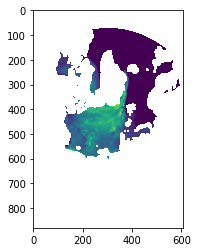

In [15]:
plt.imshow(nc1['sisnthick'][0])

# Feature Extraction

In [24]:
def save_pca(filename, pca):
    '''Save PCA in .pkl file
    '''
    print(f'PCA saved: \n{filename}')
    pkl.dump(pca, open(filename,"wb"))
    return

### 1) PCA of SIT with no sit assimilation:

In [17]:
from importlib import reload
reload(feature_pca);

login-1.fram.sigma2.no
fram detected


In [18]:
# Compute PCA

data_kind = "nosit"
n_components = load_config.get_n_components(data_kind, file_config)
file_save = os.path.join(rootdir, pca_dir, f'pca_{target_field}_{n_components}N_noSITass.pkl')

In [19]:
nc = xr.open_mfdataset(listfile, combine='nested', concat_dim='time')


In [20]:
nc

<xarray.Dataset>
Dimensions:        (time: 3016, y: 881, x: 609, depth: 40)
Coordinates:
  * time           (time) datetime64[ns] 2010-09-29 2010-09-30 ... 2018-12-31
  * depth          (depth) float32 0.0 2.0 4.0 6.0 ... 3e+03 3.5e+03 4e+03
    latitude       (y, x) float32 dask.array<chunksize=(881, 609), meta=np.ndarray>
    longitude      (y, x) float32 dask.array<chunksize=(881, 609), meta=np.ndarray>
  * x              (x) float32 -38.0 -37.88 -37.75 -37.62 ... 37.75 37.88 38.0
  * y              (y) float32 -55.0 -54.88 -54.75 -54.62 ... 54.75 54.88 55.0
Data variables: (12/15)
    bottomT        (time, y, x) float32 dask.array<chunksize=(1, 881, 609), meta=np.ndarray>
    mlotst         (time, y, x) float32 dask.array<chunksize=(1, 881, 609), meta=np.ndarray>
    model_depth    (time, y, x) float32 dask.array<chunksize=(1, 881, 609), meta=np.ndarray>
    siconc         (time, y, x) float32 dask.array<chunksize=(1, 881, 609), meta=np.ndarray>
    sisnthick      (time, y, x) float32 dask.array<chunksize=(1, 881, 609), meta=np.ndarray>
    sithick        (time, y, x) float32 dask.array<chunksize=(1, 881, 609), meta=np.ndarray>
    ...             ...
    thetao         (time, depth, y, x) float32 dask.array<chunksize=(1, 40, 881, 609), meta=np.ndarray>
    vxo            (time, depth, y, x) float32 dask.array<chunksize=(1, 40, 881, 609), meta=np.ndarray>
    vxsi           (time, y, x) float32 dask.array<chunksize=(1, 881, 609), meta=np.ndarray>
    vyo            (time, depth, y, x) float32 dask.array<chunksize=(1, 40, 881, 609), meta=np.ndarray>
    vysi           (time, y, x) float32 dask.array<chunksize=(1, 881, 609), meta=np.ndarray>
    zos            (time, y, x) float32 dask.array<chunksize=(1, 881, 609), meta=np.ndarray>
Attributes:
    title:        Arctic Ocean Physics Reanalysis
    institution:  NERSC, Jahnebakken 3, N-5007 Bergen, Norway
    history:      20220905:Created by program hyc2proj, version V0.3
    source:       NERSC-HYCOM model fields
    references:   http://topaz.nersc.no
    field_type:   Files based on file type nersc_daily
    Conventions:  CF-1.4
    field_date:   2010-09-29
    version:      v4c

In [ ]:
lim_jdm

In [98]:
# new default
# lim_jdm = (300,629)
# lim_idm = (100, 550)

In [21]:
nc_sel = nc['sithick'].isel(y=slice(*lim_jdm), x=slice(*lim_idm))

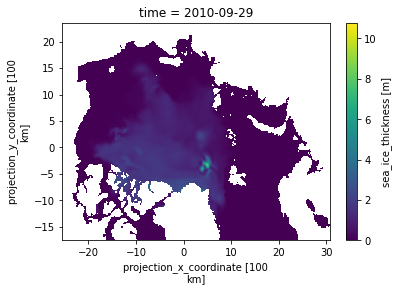

In [22]:
nc_sel[0].plot()

In [23]:
mu =  nc_sel.mean(dim='time').compute()
Xf = nc_sel.compute()


In [24]:
Xf.shape

(3016, 329, 450)

In [25]:
maskok = (np.isfinite(Xf)).all(dim='time')


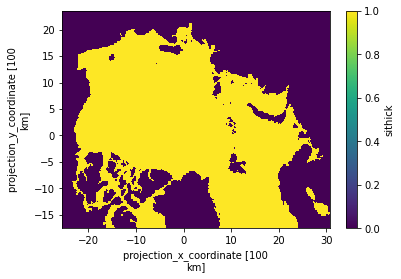

In [26]:
maskok.plot()

In [27]:
mskok1d= maskok.stack(z=('y','x'))
           
X1d =  Xf.stack(z=('y','x'))
X1d_nonan = X1d.where(mskok1d, drop=True)

In [28]:
X1d_nonan;

In [29]:
np.mean(X1d_nonan, axis=(1))

<xarray.DataArray 'sithick' (time: 3016)>
array([0.43213037, 0.43320653, 0.434319  , ..., 0.8363297 , 0.84173423,
       0.8476665 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2010-09-29 2010-09-30 ... 2018-12-31

In [30]:
pca = PCA(n_components=n_components).fit(X1d_nonan)

In [31]:
save_pca(file_save, pca)

PCA saved: 
/nird/projects/nird/NS2993K/Leo/results/pca_i100-550_j300-629/pca_sithick_4N_noSITass.pkl


In [32]:
# Save Xf to netcdf for retrieve PC and EOF later
filename = os.path.join(rootdir, pca_dir, f"{target_field}_forecast_noSITass.nc")
Xf.to_netcdf(filename)

----

In [6]:
                
def compute_eof(n_components, X, pca, maskok):
    """ Compute EOF
    In:
        n_components : int
        X            : xarray.core.dataarray.DataArray
        pca          : sklearn.decomposition._pca.PCA
        maskok       : xarray.core.dataarray.DataArray
        
    Out:
        EOF1d        : xarray.core.dataarray.DataArray
        EOF2d        : xarray.core.dataarray.DataArray
    """
    X1d =  X.stack(z=('y','x'))
    mskok1d= maskok.stack(z=('y','x'))
    
    EOF1d = xr.DataArray(np.nan*np.ones ((n_components,X1d.shape[1])),dims=['comp','z'])
    multi_index = pd.MultiIndex.from_tuples(X1d.coords['z'].data,names=['jdim','idim'])
    EOF1d = EOF1d.assign_coords(z=('z',multi_index))
    EOF1d[{'z':mskok1d}] = pca.components_
    EOF2d= EOF1d.unstack('z')
    
    return EOF1d, EOF2d

In [34]:
# Compute EOF
EOF1d, EOF2d = compute_eof(n_components, Xf, pca, maskok)

In [35]:
#ntest, nval, ntrain, nsplit = tardis_ml.compute_dataset_splits(Xf1d_nonan)

# #TODO : delete entre (remplate provisoirement ligne au dessus attend import)
# nn = Xf1d_nonan.shape[0]
# #Ideally one year of validation for hyperparameter tuning and one year of test
# ntest = 365
# nval = 360 #a bit less than one year to fit one more split
# ntrain = nn - ntest - nval

# ntrain = nn - ntrain
# ntrain = 0
# # TODO : delete entre



PCs_f = xr.DataArray(pca.transform(X1d_nonan), dims=['time','comp'])

/cluster/home/leoede/tardis/tardis-ml/src/utils/modif_plot.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lably, fontsize = s)
/cluster/home/leoede/tardis/tardis-ml/src/utils/modif_plot.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lablx, fontsize = s)


Saved as: /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_7F_rw21d_N4444_H1333_Hn0000_sithick_noname_220928-114559/figures/sithick_PCA_noSIT_EOF_PC.png


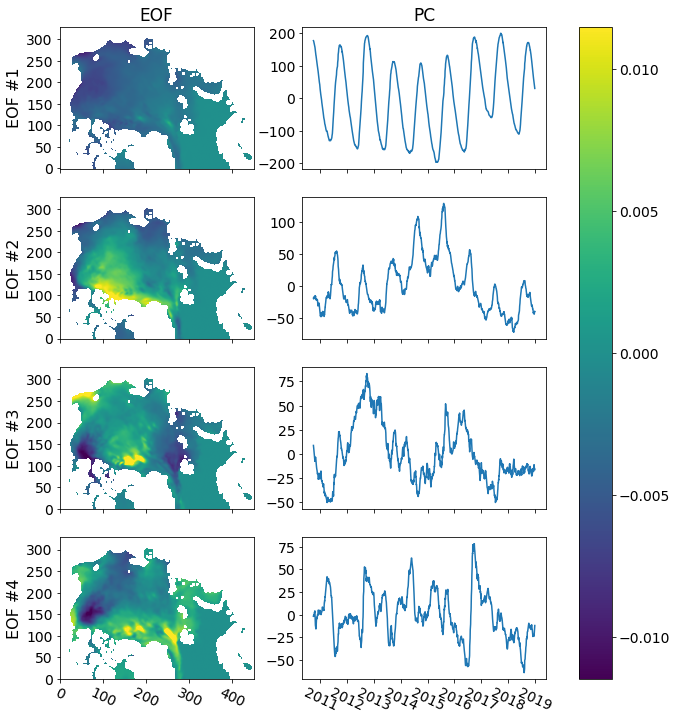

In [36]:
filename = f'{rootdir}{fig_dir}{target_field}_PCA_noSIT_EOF_PC.png'
visualize_pca.plot_save_eof(chrono, 4, n_components, EOF2d, PCs_f, target_field, 0, ofile=filename)

----

----

### 2) PCA of SIT with sit assimilation:

In [7]:
# Compute PCA

data_kind = "withsit"
n_components = load_config.get_n_components(data_kind, file_config)
file_save = os.path.join(rootdir, pca_dir, f'pca_{target_field}_{n_components}N_SITass.pkl')

In [8]:
# chrono from files in TP4c
listfile = sorted(glob(os.path.join(rootdir + withsit_dir,'*.nc')))
listfields = sorted([os.path.basename(name) for name in listfile])

dt = np.array([datetime.strptime(lf[:8], "%Y%m%d") for lf in listfields])
chrono_w = pd.DataFrame({'date':dt})        

In [9]:
chrono_w

,date
0,2010-01-01
1,2010-01-02
2,2010-01-03
3,2010-01-04
4,2010-01-05
...,...
3282,2018-12-27
3283,2018-12-28
3284,2018-12-29
3285,2018-12-30


In [10]:
nc = xr.open_mfdataset(listfile, combine='nested', concat_dim='time')


In [11]:
nc

<xarray.Dataset>
Dimensions:        (time: 3287, y: 881, x: 609, depth: 40)
Coordinates:
  * time           (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2018-12-31
  * depth          (depth) float32 0.0 2.0 4.0 6.0 ... 3e+03 3.5e+03 4e+03
    latitude       (y, x) float32 dask.array<chunksize=(881, 609), meta=np.ndarray>
    longitude      (y, x) float32 dask.array<chunksize=(881, 609), meta=np.ndarray>
  * x              (x) float32 -38.0 -37.88 -37.75 -37.62 ... 37.75 37.88 38.0
  * y              (y) float32 -55.0 -54.88 -54.75 -54.62 ... 54.75 54.88 55.0
Data variables: (12/15)
    bottomT        (time, y, x) float32 dask.array<chunksize=(1, 881, 609), meta=np.ndarray>
    mlotst         (time, y, x) float32 dask.array<chunksize=(1, 881, 609), meta=np.ndarray>
    model_depth    (time, y, x) float32 dask.array<chunksize=(1, 881, 609), meta=np.ndarray>
    siconc         (time, y, x) float32 dask.array<chunksize=(1, 881, 609), meta=np.ndarray>
    sisnthick      (time, y, x) float32 dask.array<chunksize=(1, 881, 609), meta=np.ndarray>
    sithick        (time, y, x) float32 dask.array<chunksize=(1, 881, 609), meta=np.ndarray>
    ...             ...
    thetao         (time, depth, y, x) float32 dask.array<chunksize=(1, 40, 881, 609), meta=np.ndarray>
    vxo            (time, depth, y, x) float32 dask.array<chunksize=(1, 40, 881, 609), meta=np.ndarray>
    vxsi           (time, y, x) float32 dask.array<chunksize=(1, 881, 609), meta=np.ndarray>
    vyo            (time, depth, y, x) float32 dask.array<chunksize=(1, 40, 881, 609), meta=np.ndarray>
    vysi           (time, y, x) float32 dask.array<chunksize=(1, 881, 609), meta=np.ndarray>
    zos            (time, y, x) float32 dask.array<chunksize=(1, 881, 609), meta=np.ndarray>
Attributes:
    title:        Arctic Ocean Physics Reanalysis
    institution:  NERSC, Jahnebakken 3, N-5007 Bergen, Norway
    history:      20220826:Created by program hyc2proj, version V0.3
    source:       NERSC-HYCOM model fields
    references:   http://topaz.nersc.no
    field_type:   Files based on file type nersc_daily
    Conventions:  CF-1.4
    field_date:   2010-01-01
    version:      v4b

In [133]:
lim_jdm = (300,629)

In [134]:
lim_idm = (100, 550)

In [12]:
nc_sel = nc['sithick'].isel(y=slice(*lim_jdm), x=slice(*lim_idm))

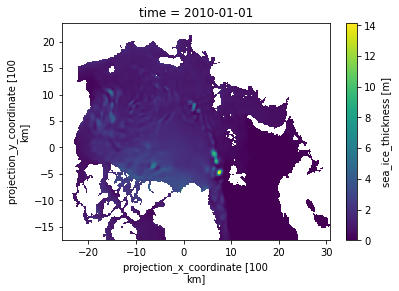

In [13]:
nc_sel[0].plot()

In [14]:
mu =  nc_sel.mean(dim='time').compute()
Xf = nc_sel.compute()


In [15]:
Xf.shape

(3287, 329, 450)

In [16]:
maskok = (np.isfinite(Xf)).all(dim='time')


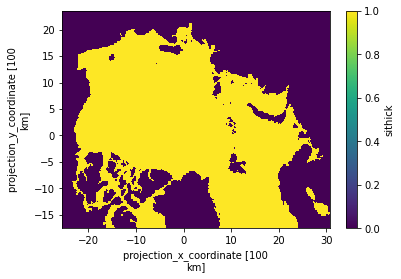

In [17]:
maskok.plot()

In [18]:
mskok1d= maskok.stack(z=('y','x'))
           
X1d =  Xf.stack(z=('y','x'))
X1d_nonan = X1d.where(mskok1d, drop=True)

In [19]:
X1d_nonan;

In [20]:
np.mean(X1d_nonan, axis=(1))

<xarray.DataArray 'sithick' (time: 3287)>
array([1.0383762, 1.0438204, 1.0492029, ..., 1.0684727, 1.0719467,
       1.0762249], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2018-12-31

In [22]:
pca = PCA(n_components=n_components).fit(X1d_nonan)

In [25]:
save_pca(file_save, pca)

PCA saved: 
/nird/projects/nird/NS2993K/Leo/results/pca_i100-550_j300-629/pca_sithick_4N_SITass.pkl


In [26]:
# Save Xf to netcdf for retrieve PC and EOF later
filename = os.path.join(rootdir, pca_dir, f"{target_field}_forecast_SITass.nc")
Xf.to_netcdf(filename)

In [27]:
# Compute EOF
EOF1d, EOF2d = compute_eof(n_components, Xf, pca, maskok)

In [39]:
EOF1d.shape

(4, 148050)

In [28]:
#ntest, nval, ntrain, nsplit = tardis_ml.compute_dataset_splits(Xf1d_nonan)

# #TODO : delete entre (remplate provisoirement ligne au dessus attend import)
# nn = Xf1d_nonan.shape[0]
# #Ideally one year of validation for hyperparameter tuning and one year of test
# ntest = 365
# nval = 360 #a bit less than one year to fit one more split
# ntrain = nn - ntest - nval

# ntrain = nn - ntrain
# ntrain = 0
# # TODO : delete entre



PCs_f = xr.DataArray(pca.transform(X1d_nonan), dims=['time','comp'])

/cluster/home/leoede/tardis/tardis-ml/src/utils/modif_plot.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lably, fontsize = s)
/cluster/home/leoede/tardis/tardis-ml/src/utils/modif_plot.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lablx, fontsize = s)


Saved as: /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_7F_rw21d_N4444_H1333_Hn0000_sithick_noname_220928-130121/figures/sithick_PCA_SIT_EOF_PC.png


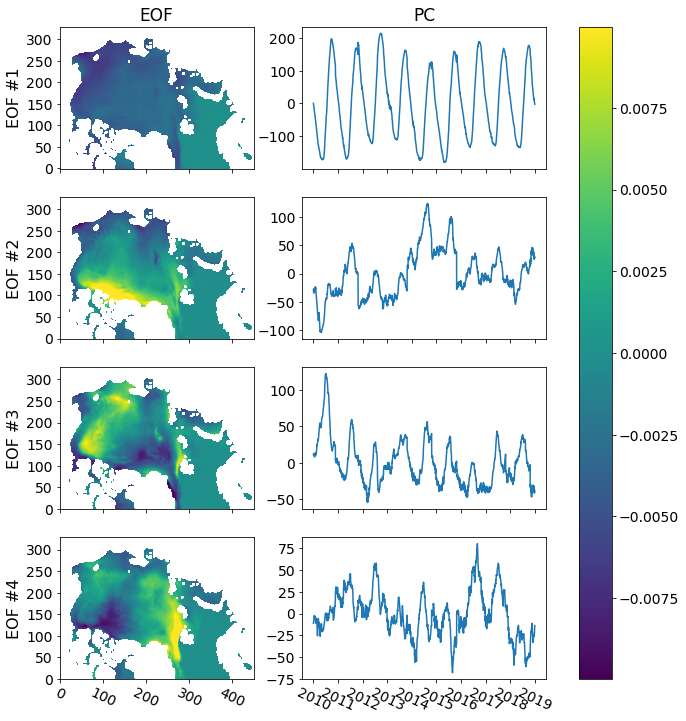

In [29]:
filename = f'{rootdir}{fig_dir}{target_field}_PCA_SIT_EOF_PC.png'
visualize_pca.plot_save_eof(chrono_w, n_components, n_components, EOF2d, PCs_f, target_field, 0, ofile=filename)

----

----

----
### Visualize results


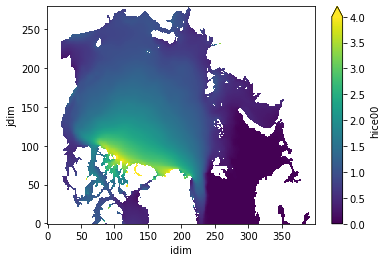

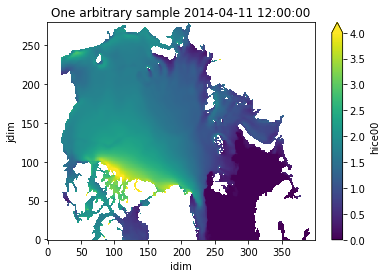

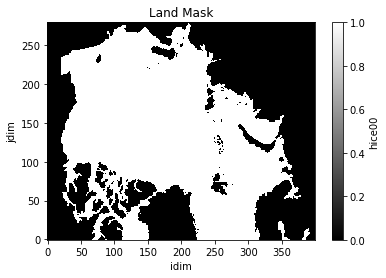

In [12]:
# Visualize some data

mu_f.plot(vmax=4);
plt.show()

Xf.isel(rdim=idate).plot(vmax=4)
plt.title(f'One arbitrary sample {chrono.iloc[idate]}');
plt.show()

maskok_f.plot(cmap=plt.get_cmap('gray'));
plt.title('Land Mask');
plt.show()

In [13]:
# plot current zone on Arctic map

_, area_name = tardisml_utils.get_area_name(lim_idm, lim_jdm)
if area_name != 'artc':
    plot_land_mask(lim_idm, lim_jdm, rootdir, pca_dir, savefig=True)
else:
    plot_land_mask(lim_idm, lim_jdm, rootdir, pca_dir, drwzne=False, savefig=True)


FileNotFoundError: [Errno 2] No such file or directory: b'/nird/projects/nird/NS2993K/Leo/results/pca_8N_i200-600_j600-881/land_mask_i200-600_j600-881.nc'

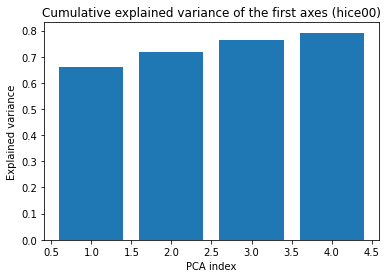

In [14]:
# Visualize cumulative explained variance of the first axes

filename = f'{rootdir}{fig_dir}{target_field}_PCA_noSIT_cumvar.png'
visualize_pca.plot_save_pca_variance(n_components, pca_f, target_field, filename)

In [76]:
#ntest, nval, ntrain, nsplit = tardis_ml.compute_dataset_splits(Xf1d_nonan)

#TODO : delete entre (remplate provisoirement ligne au dessus attend import)
nn = Xf1d_nonan.shape[0]
#Ideally one year of validation for hyperparameter tuning and one year of test
ntest = 365
nval = 360 #a bit less than one year to fit one more split
ntrain = nn - ntest - nval

ntrain = nn - ntrain
ntrain = 0
# TODO : delete entre



PCs_f = xr.DataArray(pca_f.transform(Xf1d_nonan), dims=['rdim','comp'])

In [87]:
filename = f'{rootdir}{fig_dir}{target_field}_PCA_noSIT_EOF_PC.png'
visualize_pca.plot_save_eof(chrono, 4, n_components, EOF2d, PCs_f, target_field, ntrain, ofile=filename)

NameError: name 'PCs_f' is not defined

In [81]:
# Reconstruction TODO use inverse transform/kernel PCA ?
Xf_rec = xr.dot(EOF2d,PCs_f)+ mu_f

# Reconstruction 3 EOF
Xf_rec3 = xr.dot(EOF2d.isel(comp=slice(0,3)),PCs_f.isel(comp=slice(0,3))) + mu_f

In [85]:
filename = f'{rootdir}{fig_dir}REC_TOPAZ_{target_field}_diff.png'

visualize_pca.plot_save_reconstruction_eof(chrono, idate, Xf, Xf_rec, ntrain, filename)

Saved as /nird/projects/nird/NS2993K/Leo/results/rf_Npred22_8F_rw21d_N4444_H1333_Hn0000_hice00_artc_220824-091938/figures/REC_TOPAZ_hice00_diff.png


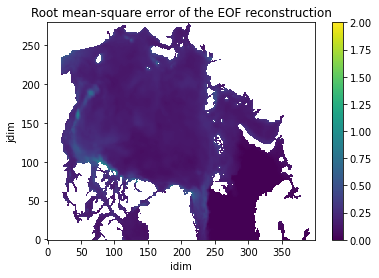

In [29]:
RMSE_recf = np.sqrt((np.square(Xf_rec-Xf[ntrain:])).mean(dim='rdim'))

RMSE_recf.plot(vmax=2)
plt.title('Root mean-square error of the EOF reconstruction');
#filename = f'RMSE_EOF_rec.png'
#plt.savefig(f"{rootdir}{fig_dir}{filename}")

### 2) PCA of SIT with sit assimilation (reference field)
Actually we don't represent the PCA of the SIT field but the PCA of the difference between SIT (with DA) and SIT (no DA), called 'model error'

In [64]:
data_kind = "withsit"
n_components = 8  #load_config.get_n_components(data_kind, file_config)
#file_sit_assimilate = os.path.join(tardisml_utils.rootdir, pca_dir, f"{target_field}_forecast_SITass.nc")
#filename = os.path.join(rootdir,pca_dir,f'pca_{target_field}_{n_components}N_SITerr.pkl')  # SITass-SITnoass

mu_a, Xa, Xa1d_nonan, pca_a, maskok_a, nc_a = feature_pca.compute_pca(chrono, n_components, withsit_dir, target_field, lim_idm, lim_jdm, template, '', nc_f, pca_dir, maskok_f)

TODO : redo by combinbing forecast and analyis mask (even though they should be the same)


In [13]:
# Save Xa to netcdf for retrieve PC and EOF later

filename = os.path.join(rootdir,pca_dir,f"{target_field}_forecast_SITerr.nc")
Xa.to_netcdf(filename)
print(f'SIT err saved in: {filename}')

PermissionError: [Errno 13] Permission denied: b'/nird/projects/nird/NS2993K/Leo/results/pca_i200-600_j600-881/hice00_forecast_SITerr.nc'

----
### Visualize results


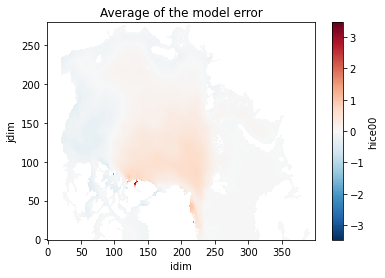

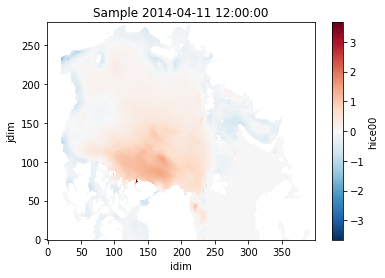

In [32]:
mu_a.plot()
plt.title('Average of the model error')
plt.show()

Xa.isel(rdim=idate).plot()
plt.title(f'Sample {chrono.iloc[idate]}');
plt.show()

model error corresponds to (Sea Ice thickness) assimilated - forecast\
it shows the biais of the model and the possibility to correct those systematics errors using machine learning

The model error shows higher RMSE in comparison to the RMSE of the EOF reconstruction.
This suggests that the EOF method is able to give smaller errors than the model, and therefore can be used as a statistical correction method.

In [33]:
visualize_pca.plot_save_pca_variance(n_components, pca_a, target_field, "")

In [65]:
EOF1d_a, EOF2d_a = feature_pca.compute_eof(n_components, Xa, pca_a, maskok_a)

In [66]:
PCs_a = xr.DataArray(pca_a.transform(Xa1d_nonan), dims=['rdim','comp'])

In [91]:
from importlib import reload
reload(visualize_error);

/cluster/home/leoede/tardis/tardis-ml/src/utils/modif_plot.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lably, fontsize = s)
/cluster/home/leoede/tardis/tardis-ml/src/utils/modif_plot.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lablx, fontsize = s)


Saved as: /nird/projects/nird/NS2993K/Leo/results/rf_Npred22_8F_rw21d_N4444_H1333_Hn0000_hice00_artc_220824-091938/figures/hice00_PCA_withSIT_EOF_PC_01.png


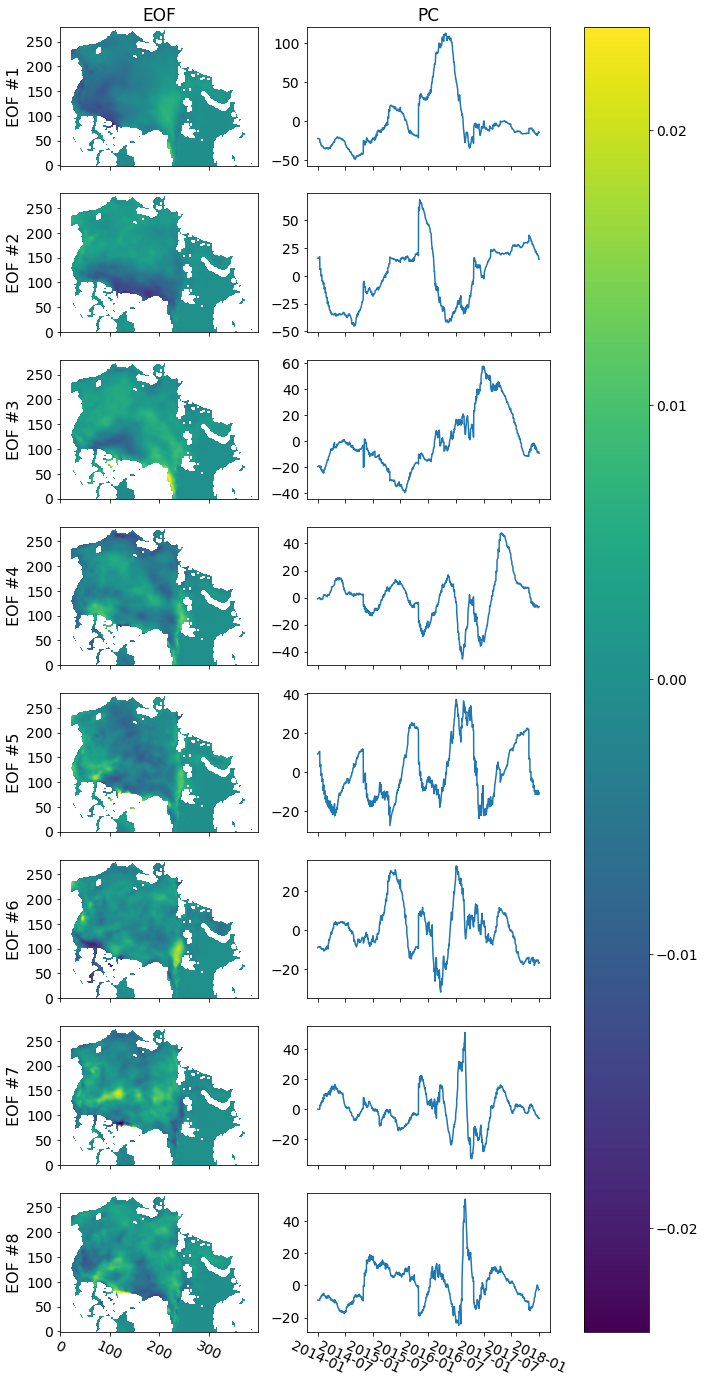

In [67]:
filename = f'{rootdir}{fig_dir}{target_field}_PCA_withSIT_EOF_PC_01.png'
visualize_pca.plot_save_eof(chrono, 8, n_components, EOF2d_a, PCs_a, target_field, 0, ofile=filename)

Fig saved as: /nird/projects/nird/NS2993K/Leo/results/rf_Npred22_8F_rw21d_N4444_H1333_Hn0000_hice00_artc_220824-091938/figures/hice00_PCA_Xe_cumvar_01.png


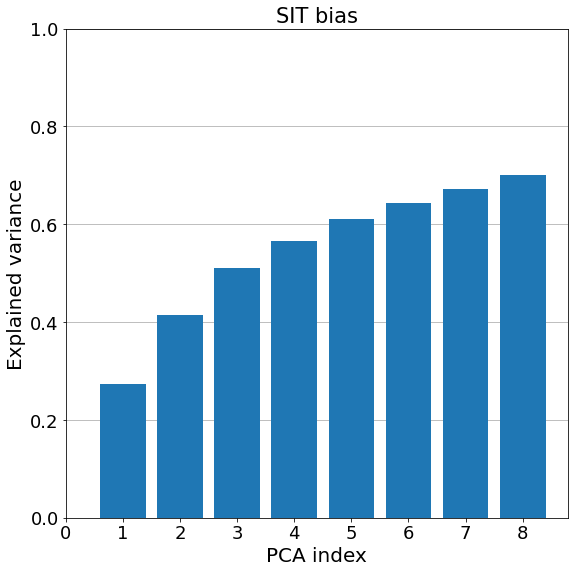

In [69]:
# Visualize cumulative explained variance of the first axes

filename = f'{rootdir}{fig_dir}{target_field}_PCA_Xe_cumvar_01.png'
visualize_pca.plot_pca_variance(n_components, pca_a, target_field, True, filename)


In [72]:
# Reconstruction
Xa_rec = xr.dot(EOF2d_a,PCs_a)+ mu_a

In [92]:
filename = f"{rootdir}{fig_dir}RMSE_model_error_EOF_rec_true.png"
visualize_error.plot_rmse(Xf, Xf_rec, Xa, Xa_rec, ntrain, filename=filename)

Average of the model error: <xarray.DataArray 'hice00' ()>
array(0.2895862, dtype=float32)
Average of the model error reconstruction:<xarray.DataArray ()>
array(0.12947517)
Saved as: /nird/projects/nird/NS2993K/Leo/results/rf_Npred22_8F_rw21d_N4444_H1333_Hn0000_hice00_artc_220824-091938/figures/RMSE_model_error_EOF_rec_true.png


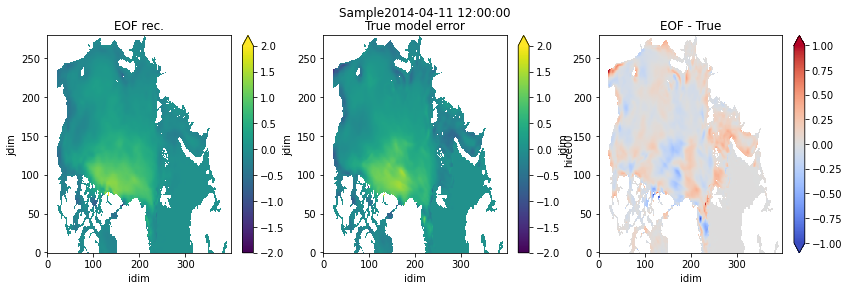

In [94]:
fig, ax = plt.subplots(ncols=3, figsize=(14,4))
fig.suptitle(f'Sample{chrono.iloc[idate]}')

Xa_rec.isel(rdim=idate).plot(ax=ax[0],vmin=-2, vmax=2)
Xa.isel(rdim=idate).plot(ax=ax[1],vmin=-2, vmax=2)
(Xa_rec-Xa).isel(rdim=idate).plot(ax=ax[2], vmin=-1, vmax=1, cmap=plt.get_cmap('coolwarm'))
ax[0].set_title('EOF rec.')
ax[1].set_title('True model error')
ax[2].set_title('EOF - True')

filename = f'RMSE_EOF_rec_diff_True.png'
plt.savefig(f"{rootdir}{fig_dir}{filename}")


In [95]:
print(f"{rootdir}{fig_dir}{filename}")

/nird/projects/nird/NS2993K/Leo/results/rf_Npred22_8F_rw21d_N4444_H1333_Hn0000_hice00_artc_220824-091938/figures/RMSE_EOF_rec_diff_True.png


----

----

## 3) Bias of ASS - no ASS (TOPAZ4b - TOPAZ4c)

In [168]:
filename = os.path.join(rootdir, pca_dir, f"{target_field}_forecast_noSITass.nc")
Xf = load_data.load_nc(filename, 'sithick', True)

In [169]:
filename = os.path.join(rootdir, pca_dir, f"{target_field}_forecast_SITass.nc")
Xa = load_data.load_nc(filename, 'sithick', True)

In [170]:
Xfm = Xf.mean(dim=('y','x')).compute()
Xam = Xa.mean(dim=('y','x')).compute()

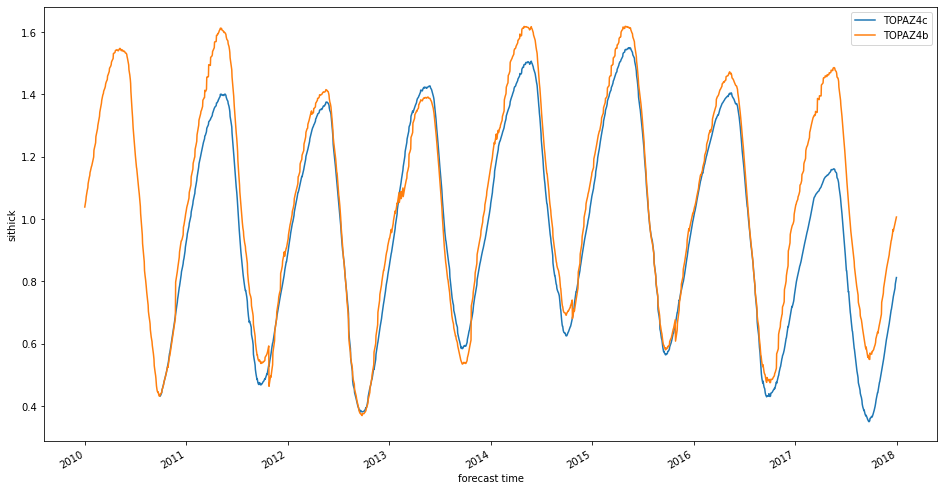

In [186]:
fig, ax = plt.subplots(figsize=(16, 8))
Xfm.plot(label='TOPAZ4c')
Xam.plot(label='TOPAZ4b')
plt.legend()

In [201]:
from src.utils import modif_plot

In [222]:
rootdir

'/nird/projects/nird/NS2993K/'

In [221]:
fig_dir

'Leo/results/xgb_Npred22_8F_rw21d_N4444_H1333_Hn0000_sithick_artc_220920-174631/figures/'

Saved as /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_8F_rw21d_N4444_H1333_Hn0000_sithick_artc_220920-174631/figures/TOPAZ4b_c_bias.png


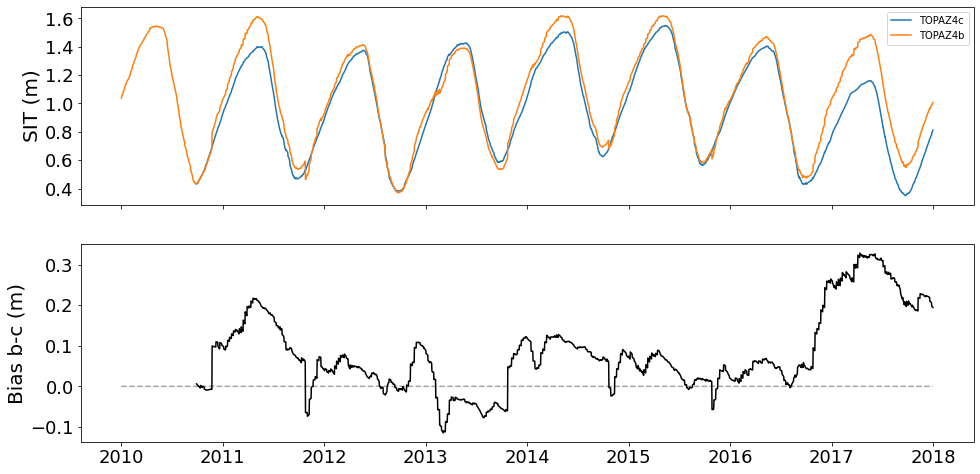

In [223]:
fig, (ax, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(16, 8))
ax.plot(chrono, Xfm, label='TOPAZ4c')
ax.plot(chrono_w, Xam, label='TOPAZ4b')
ax.set_ylabel('SIT (m)')
ax.set_xticklabels('')

ax2.plot(chrono_w, [0]*len(chrono_w), '--', c ='grey', alpha=.7)
ax2.plot(chrono, Xem, 'k')
ax2.set_xlim(ax.get_xlim())
ax2.set_ylabel(f'Bias b-c (m)')


ax.legend()

modif_plot.resize(fig, s=18)

savefig = True
if savefig:
    filename = f'TOPAZ4b_c_bias.png'
    plt.savefig(f"{rootdir}{fig_dir}{filename}")
    print(f'Saved as {rootdir}{fig_dir}{filename}')

In [172]:
Xem = Xam - Xfm

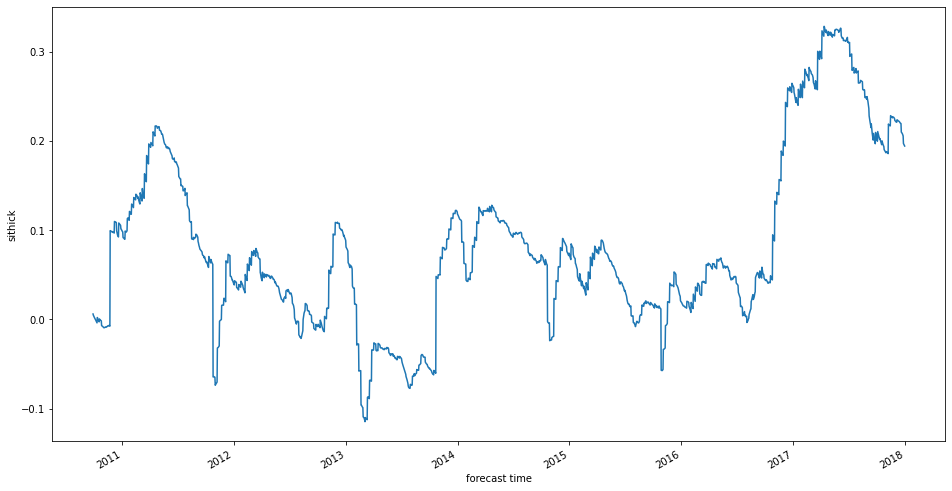

In [185]:
fig, ax = plt.subplots(figsize=(16, 8))

Xem.plot()

In [174]:
Xe = Xa - Xf

In [175]:
Xe.shape

(2651, 329, 450)

In [187]:
n_components = 8

In [188]:
maskok = (np.isfinite(Xe)).all(dim='time')
mskok1d= maskok.stack(z=('y','x'))
           
X1d =  Xe.stack(z=('y','x'))
X1d_nonan = X1d.where(mskok1d, drop=True)

In [192]:
pca = PCA(n_components=n_components).fit(X1d_nonan)

In [193]:
file_save = os.path.join(rootdir, pca_dir, f'pca_{target_field}_{n_components}N_SITerr.pkl')
save_pca(file_save, pca)

PCA saved: 
/nird/projects/nird/NS2993K/Leo/results/pca_i200-600_j600-881/pca_sithick_8N_SITerr.pkl


In [181]:
# Save Xf to netcdf for retrieve PC and EOF later
filename = os.path.join(rootdir, pca_dir, f"{target_field}_forecast_SITerr.nc")
Xe.to_netcdf(filename)

In [194]:
# Compute EOF
EOF1d, EOF2d = compute_eof(n_components, Xe, pca, maskok)

In [195]:
PCs_e = xr.DataArray(pca.transform(X1d_nonan), dims=['time','comp'])

Saved as: /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_8F_rw21d_N4444_H1333_Hn0000_sithick_artc_220920-174631/figures/sithick_PCA_SITerr_EOF_PC.png


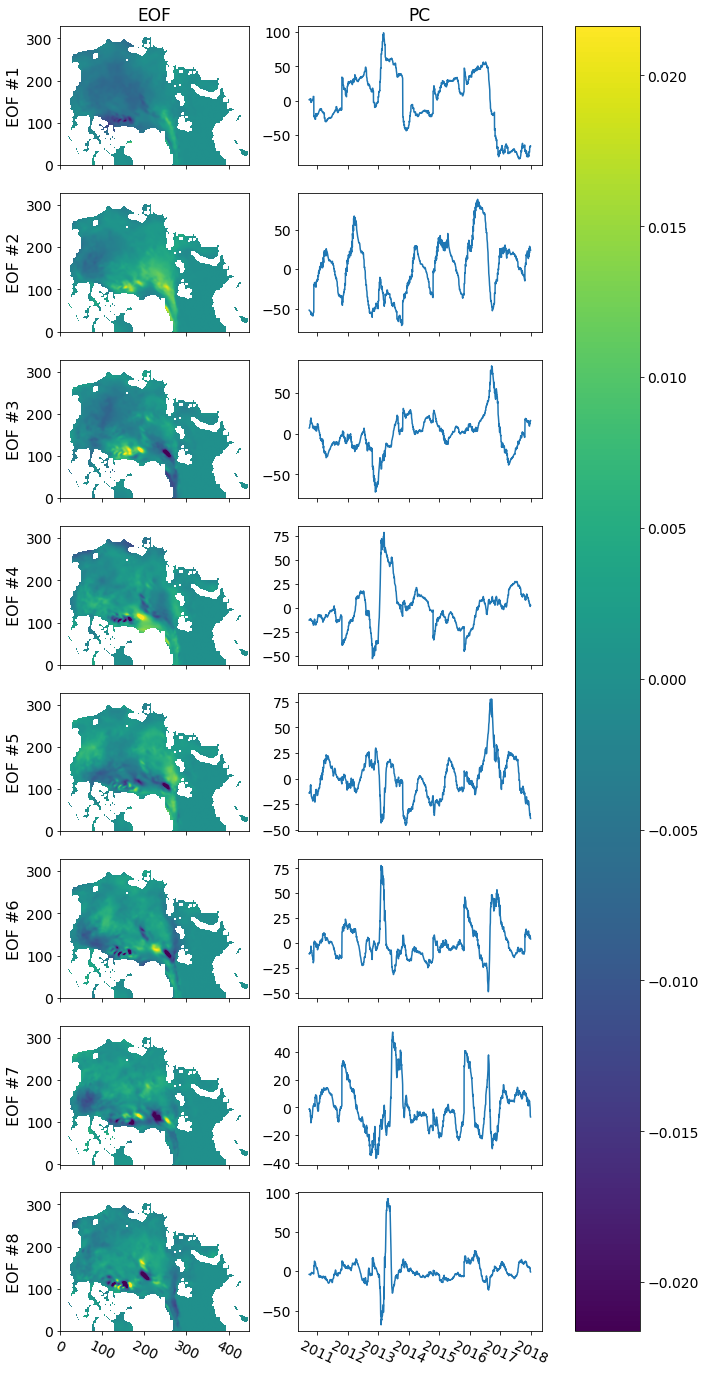

In [197]:
filename = f'{rootdir}{fig_dir}{target_field}_PCA_SITerr_EOF_PC.png'
visualize_pca.plot_save_eof(chrono, 8, n_components, EOF2d, PCs_e, target_field, 0, ofile=filename)

Fig saved as: /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_8F_rw21d_N4444_H1333_Hn0000_sithick_artc_220920-174631/figures/sithick_PCA_Xe_cumvar_01.png


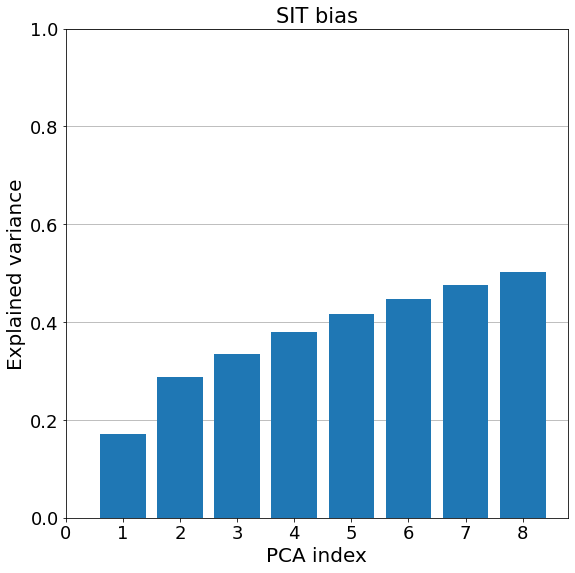

In [199]:
# Visualize cumulative explained variance of the first axes

filename = f'{rootdir}{fig_dir}{target_field}_PCA_Xe_cumvar_01.png'
visualize_pca.plot_pca_variance(n_components, pca, target_field, True, filename)


----

## PCA of the forcings

In [40]:
data_kind = "forcing"
n_components = load_config.get_n_components(data_kind, file_config)
# n_components = .95
forcings, Nf = load_data.load_forcing(forcing_fields, forcing_bdir)

mu, pca, PCs, EOFs = feature_pca.compute_pca_forcing(n_components, forcing_fields, forcings)

# TODO train/val
# TODO train/val
# TODO train/val
# TODO train/val


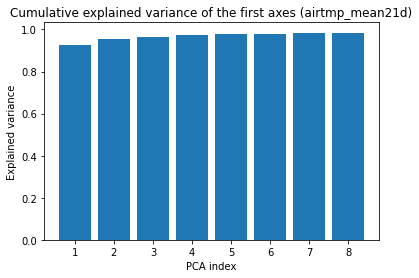

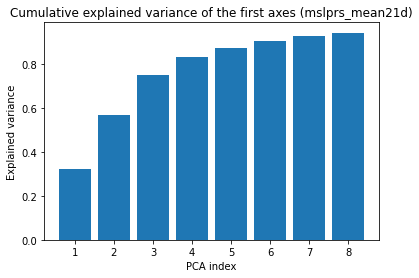

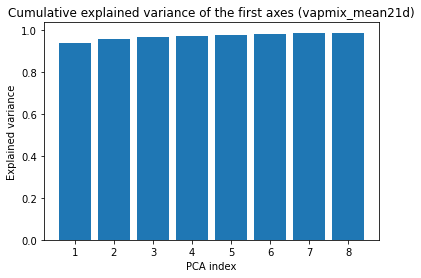

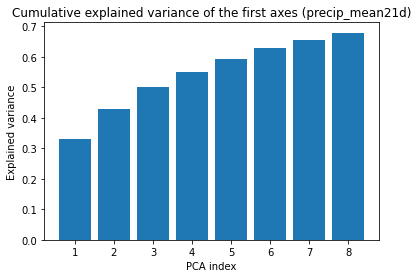

In [41]:
for i, field in enumerate(forcing_fields):
    visualize_pca.plot_save_pca_variance(n_components, pca[field], field, True, "")

Saved as /nird/projects/nird/NS2993K/Leo/results/rf_Npred50_4F_rw21d_N8888_H4444_Hn0000_hice00_artc/figures/forcing_airtmp_mean21d_EOF.png


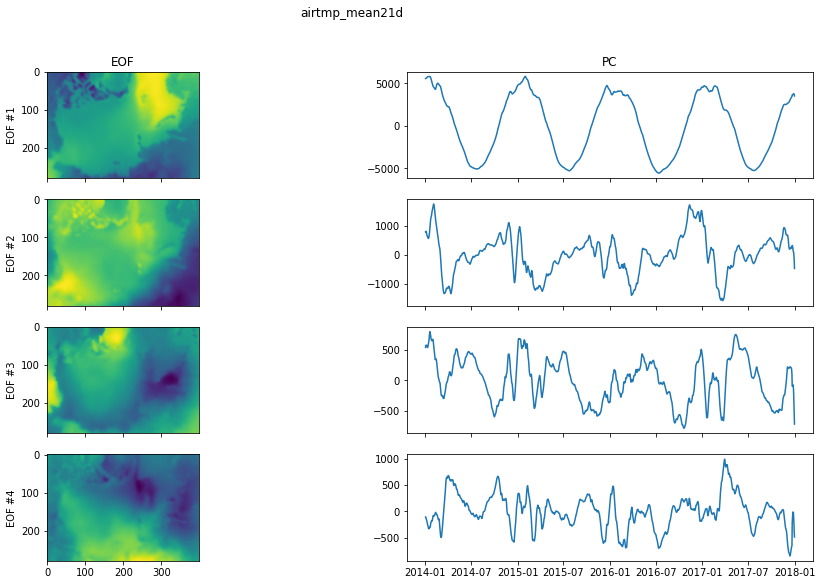

Saved as /nird/projects/nird/NS2993K/Leo/results/rf_Npred50_4F_rw21d_N8888_H4444_Hn0000_hice00_artc/figures/forcing_mslprs_mean21d_EOF.png


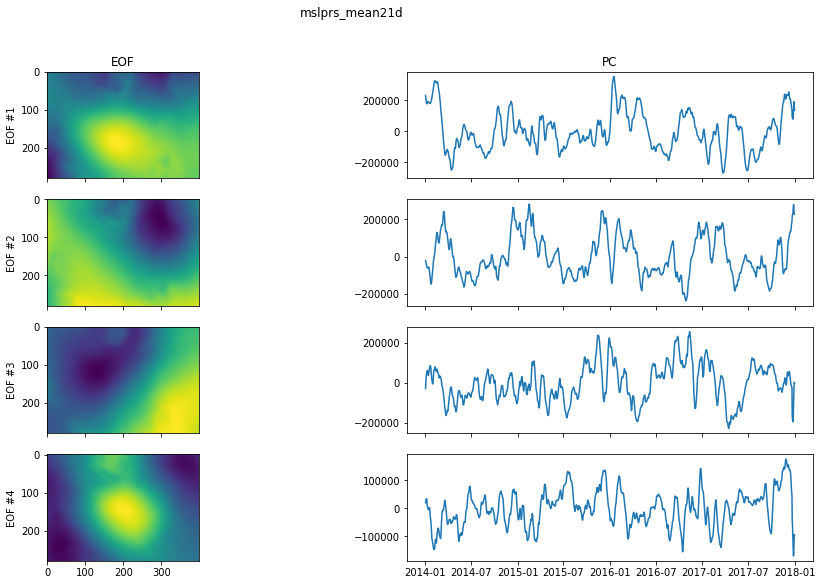

Saved as /nird/projects/nird/NS2993K/Leo/results/rf_Npred50_4F_rw21d_N8888_H4444_Hn0000_hice00_artc/figures/forcing_vapmix_mean21d_EOF.png


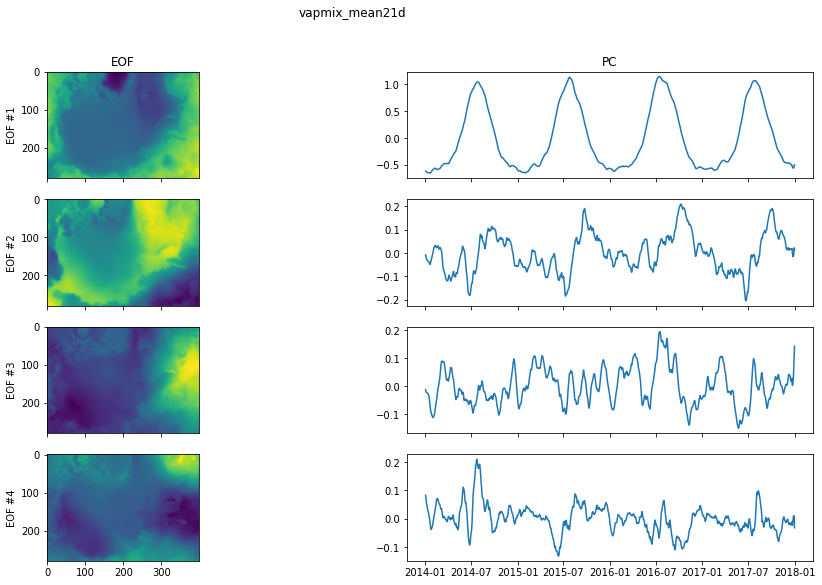

Saved as /nird/projects/nird/NS2993K/Leo/results/rf_Npred50_4F_rw21d_N8888_H4444_Hn0000_hice00_artc/figures/forcing_precip_mean21d_EOF.png


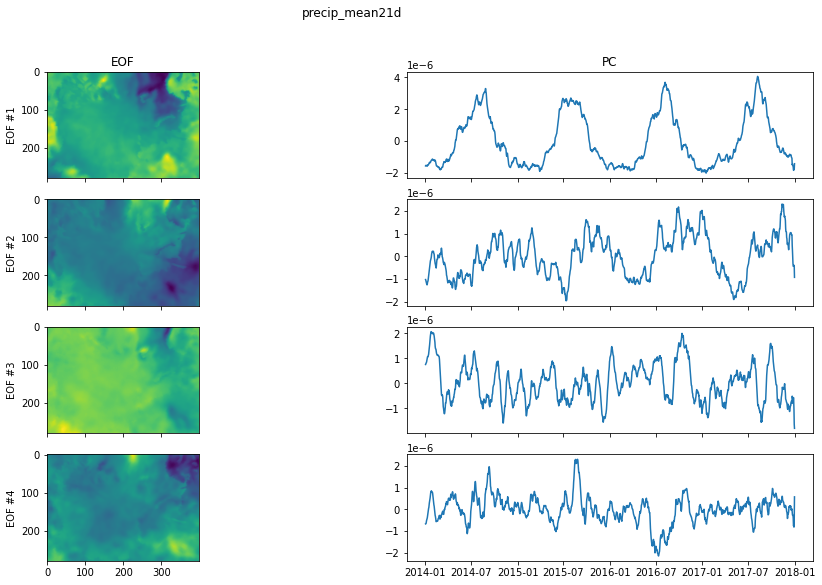

In [56]:
for field in forcing_fields:
    filename = f'{rootdir}{fig_dir}forcing_{field}_EOF.png'
    visualize_pca.plot_save_eof_np(chrono, 4, n_components, EOFs[field], PCs[field], 
                  len(forcings[forcing_fields[0]][0][:, 0]),
                  len(forcings[forcing_fields[0]][0][0, :]),
                  field, ntrain,
                  ofile=filename)

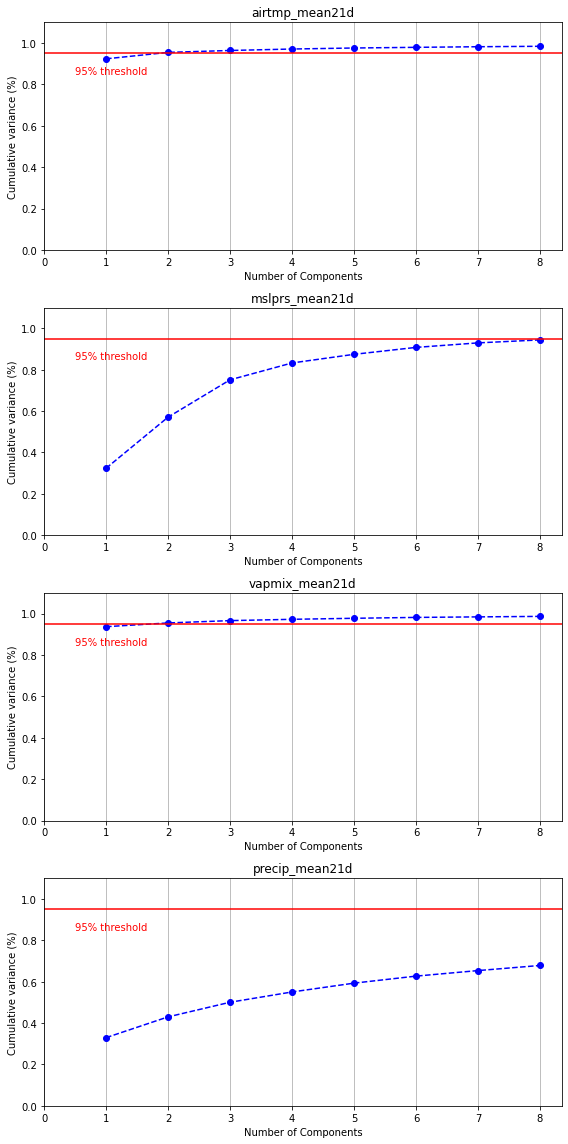

Fig saved as: /nird/projects/nird/NS2993K/Leo/results/rf_Npred50_4F_rw21d_N8888_H4444_Hn0000_hice00_artc/figures/forcings_Ncomp_variance.png


In [57]:
filename = f"{rootdir}{fig_dir}forcings_Ncomp_variance.png"
visualize_pca.plot_ncomp_var(pca, forcing_fields, True, filename)

In [ ]:
# save PCA to files for futher use
#field_str = '-'.join(config['forcing_fields'])
#filename = os.path.join(rootdir,pca_dir,f"pca_{field_str}_{n_components}N_{config['forcing_mean_days']}d.pkl")
#print(f'PCA Forcings saved: {filename}')
#pkl.dump(pca, open(filename,"wb"))

In [ ]:
# later reload the pickle file
# pca_reload = pkl.load(open(filename,'rb'))
# pca_reload

# Feature Extraction for any covariable

### PCA of covar with no sit assimilation:

In [58]:
# Compute PCA and save
data_kind = "covariable"
n_components = load_config.get_n_components(data_kind, file_config)

In [59]:
# save for plot
PCA_co = {}

In [60]:
for covar in covar_fields:
    print(covar)
    ofile = os.path.join(rootdir, pca_dir, f'pca_{covar}_{n_components}N_noSITass.pkl')
    mu_co, Xco, Xco1d_nonan, pca_co, maskok_co, nc_co = feature_pca.compute_pca(chrono, n_components, nosit_dir, covar, lim_idm, lim_jdm, template, file_save=ofile)    

    PCA_co[covar] = pca_co  # for plot_ncomp_var()
    
    # Save Xf to netcdf for retrieve PC and EOF later
    filename = os.path.join(rootdir, pca_dir, f"{covar}_forecast_noSITass.nc")
    Xco.to_netcdf(filename)

fice00
TODO : redo by combinbing forecast and analyis mask (even though they should be the same)
PCA saved: 
/nird/projects/nird/NS2993K/Leo/results/pca_i200-600_j600-881/pca_fice00_8N_noSITass.pkl
hsnw00
TODO : redo by combinbing forecast and analyis mask (even though they should be the same)
PCA saved: 
/nird/projects/nird/NS2993K/Leo/results/pca_i200-600_j600-881/pca_hsnw00_8N_noSITass.pkl


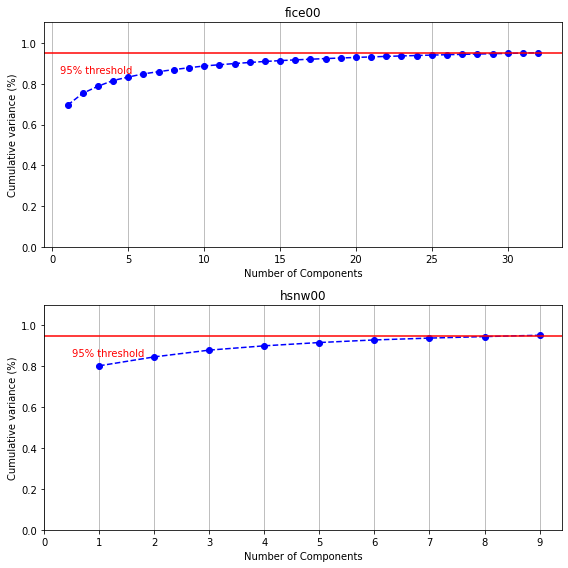

Fig saved as: /nird/projects/nird/NS2993K/Leo/results/grdbst_Npred100_4F_rw21d_N4444_H4411_Hn0000_hice00_artc/figures/covar_Ncomp_variance.png


In [38]:
filename = f"{rootdir}{fig_dir}covar_Ncomp_variance.png"
visualize_pca.plot_ncomp_var(PCA_co, covar_fields, True, filename)